# Sentiment Classification EDA & Preprocessing

This notebook performs exploratory data analysis, preprocessing, and tokenization for sentiment classification using:
- **SST-2** (Stanford Sentiment Treebank v2) - Movie review sentences
- **Yelp Review Polarity** (optional scale-up) - Business reviews

## Project Goal
Build a recurrent Transformer architecture for sentiment classification with better parameter efficiency compared to standard encoder baselines.


In [4]:
# Import necessary libraries
import os
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
from datasets import load_dataset
from transformers import AutoTokenizer
import torch
from tqdm import tqdm

# Settings
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

# Download NLTK data if needed
try:
    nltk.data.find('stopwords')
except LookupError:
    nltk.download('stopwords')
    
print("Libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")


Libraries imported successfully!
PyTorch version: 2.7.0+cu128
CUDA available: True


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\chaow\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


## 1. Load Datasets

### SST-2 (Stanford Sentiment Treebank v2)
- Part of GLUE benchmark
- ~67k training samples
- Binary sentiment classification (positive/negative)


In [5]:
# Load SST-2 dataset
print("Loading SST-2 dataset...")
sst2_dataset = load_dataset("glue", "sst2")

# Display dataset info
print(f"\nSST-2 Dataset Structure:")
print(f"Train samples: {len(sst2_dataset['train'])}")
print(f"Validation samples: {len(sst2_dataset['validation'])}")
print(f"Test samples: {len(sst2_dataset['test'])}")

# Show sample data
print("\nSample training data:")
for i in range(3):
    sample = sst2_dataset['train'][i]
    print(f"Sample {i+1}:")
    print(f"  Text: {sample['sentence']}")
    print(f"  Label: {sample['label']} ({'positive' if sample['label'] == 1 else 'negative'})")


Loading SST-2 dataset...


README.md: 0.00B [00:00, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


train-00000-of-00001.parquet:   0%|          | 0.00/3.11M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


validation-00000-of-00001.parquet:   0%|          | 0.00/72.8k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


test-00000-of-00001.parquet:   0%|          | 0.00/148k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/67349 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/872 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1821 [00:00<?, ? examples/s]


SST-2 Dataset Structure:
Train samples: 67349
Validation samples: 872
Test samples: 1821

Sample training data:
Sample 1:
  Text: hide new secretions from the parental units 
  Label: 0 (negative)
Sample 2:
  Text: contains no wit , only labored gags 
  Label: 0 (negative)
Sample 3:
  Text: that loves its characters and communicates something rather beautiful about human nature 
  Label: 1 (positive)


## 2. Convert to DataFrames for Analysis


In [6]:
# Convert SST-2 to DataFrames for easier analysis
sst2_train_df = pd.DataFrame(sst2_dataset['train'])
sst2_val_df = pd.DataFrame(sst2_dataset['validation'])

# Add text length column
sst2_train_df['text_length'] = sst2_train_df['sentence'].str.len()
sst2_val_df['text_length'] = sst2_val_df['sentence'].str.len()

# Add word count column
sst2_train_df['word_count'] = sst2_train_df['sentence'].str.split().str.len()
sst2_val_df['word_count'] = sst2_val_df['sentence'].str.split().str.len()

print("SST-2 Training Set Info:")
print(sst2_train_df.info())
print("\nFirst 5 samples:")
print(sst2_train_df.head())


SST-2 Training Set Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67349 entries, 0 to 67348
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   sentence     67349 non-null  object
 1   label        67349 non-null  int64 
 2   idx          67349 non-null  int64 
 3   text_length  67349 non-null  int64 
 4   word_count   67349 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 2.6+ MB
None

First 5 samples:
                                            sentence  label  idx  text_length  \
0       hide new secretions from the parental units       0    0           44   
1               contains no wit , only labored gags       0    1           36   
2  that loves its characters and communicates som...      1    2           89   
3  remains utterly satisfied to remain the same t...      0    3           56   
4  on the worst revenge-of-the-nerds clichés the ...      0    4           73   

   word_count  
0   

## 3. Exploratory Data Analysis - SST-2

### 3.1 Basic Statistics


In [7]:
# Basic statistics
print("=" * 50)
print("SST-2 DATASET STATISTICS")
print("=" * 50)

# Label distribution
print("\n1. Label Distribution:")
print("-" * 30)
print("Training set:")
train_label_counts = sst2_train_df['label'].value_counts()
print(f"  Negative (0): {train_label_counts[0]} ({train_label_counts[0]/len(sst2_train_df)*100:.1f}%)")
print(f"  Positive (1): {train_label_counts[1]} ({train_label_counts[1]/len(sst2_train_df)*100:.1f}%)")

print("\nValidation set:")
val_label_counts = sst2_val_df['label'].value_counts()
print(f"  Negative (0): {val_label_counts[0]} ({val_label_counts[0]/len(sst2_val_df)*100:.1f}%)")
print(f"  Positive (1): {val_label_counts[1]} ({val_label_counts[1]/len(sst2_val_df)*100:.1f}%)")

# Text statistics
print("\n2. Text Length Statistics:")
print("-" * 30)
print("Training set:")
print(sst2_train_df[['text_length', 'word_count']].describe())

print("\nValidation set:")
print(sst2_val_df[['text_length', 'word_count']].describe())


SST-2 DATASET STATISTICS

1. Label Distribution:
------------------------------
Training set:
  Negative (0): 29780 (44.2%)
  Positive (1): 37569 (55.8%)

Validation set:
  Negative (0): 428 (49.1%)
  Positive (1): 444 (50.9%)

2. Text Length Statistics:
------------------------------
Training set:
       text_length    word_count
count  67349.00000  67349.000000
mean      53.50559      9.409553
std       43.40738      8.073806
min        2.00000      1.000000
25%       21.00000      3.000000
50%       39.00000      7.000000
75%       74.00000     13.000000
max      268.00000     52.000000

Validation set:
       text_length  word_count
count   872.000000  872.000000
mean    105.841743   19.548165
std      48.133928    8.763900
min       6.000000    2.000000
25%      68.000000   13.000000
50%     103.000000   19.000000
75%     139.000000   26.000000
max     244.000000   47.000000


### 3.2 Visualizations


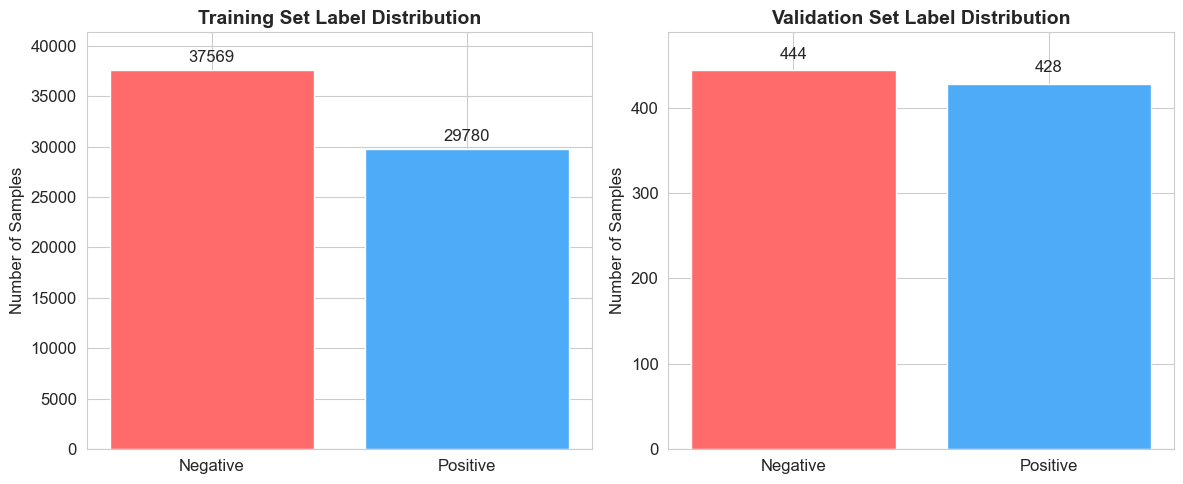

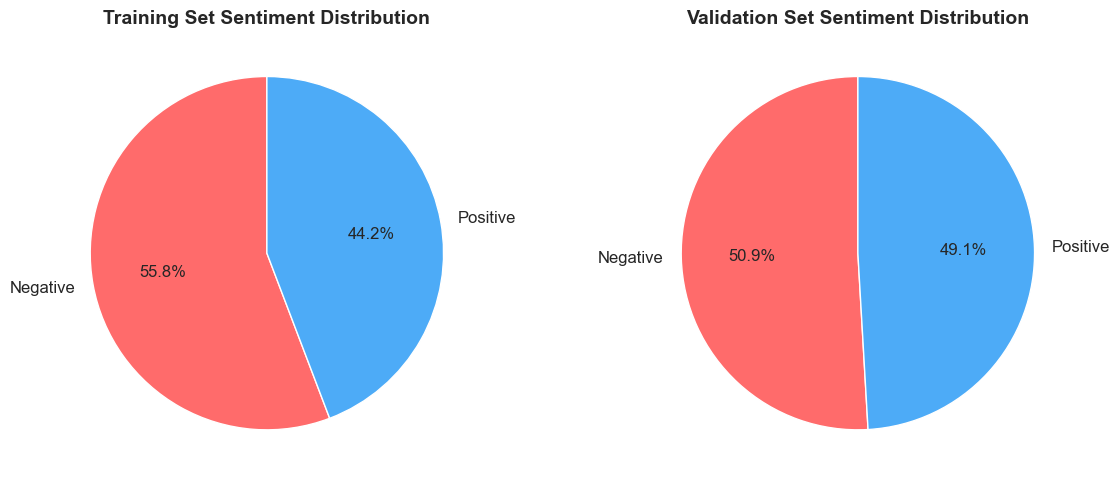

In [8]:
# Label distribution visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Training set
axes[0].bar(['Negative', 'Positive'], train_label_counts.values, color=['#ff6b6b', '#4dabf7'])
axes[0].set_title('Training Set Label Distribution', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Number of Samples')
axes[0].set_ylim(0, max(train_label_counts.values) * 1.1)

# Add count labels on bars
for i, v in enumerate(train_label_counts.values):
    axes[0].text(i, v + 500, str(v), ha='center', va='bottom')

# Validation set
axes[1].bar(['Negative', 'Positive'], val_label_counts.values, color=['#ff6b6b', '#4dabf7'])
axes[1].set_title('Validation Set Label Distribution', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Number of Samples')
axes[1].set_ylim(0, max(val_label_counts.values) * 1.1)

# Add count labels on bars
for i, v in enumerate(val_label_counts.values):
    axes[1].text(i, v + 10, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Pie chart for overall distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Training set pie chart
axes[0].pie(train_label_counts.values, labels=['Negative', 'Positive'], 
            autopct='%1.1f%%', colors=['#ff6b6b', '#4dabf7'], startangle=90)
axes[0].set_title('Training Set Sentiment Distribution', fontsize=14, fontweight='bold')

# Validation set pie chart
axes[1].pie(val_label_counts.values, labels=['Negative', 'Positive'], 
            autopct='%1.1f%%', colors=['#ff6b6b', '#4dabf7'], startangle=90)
axes[1].set_title('Validation Set Sentiment Distribution', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()


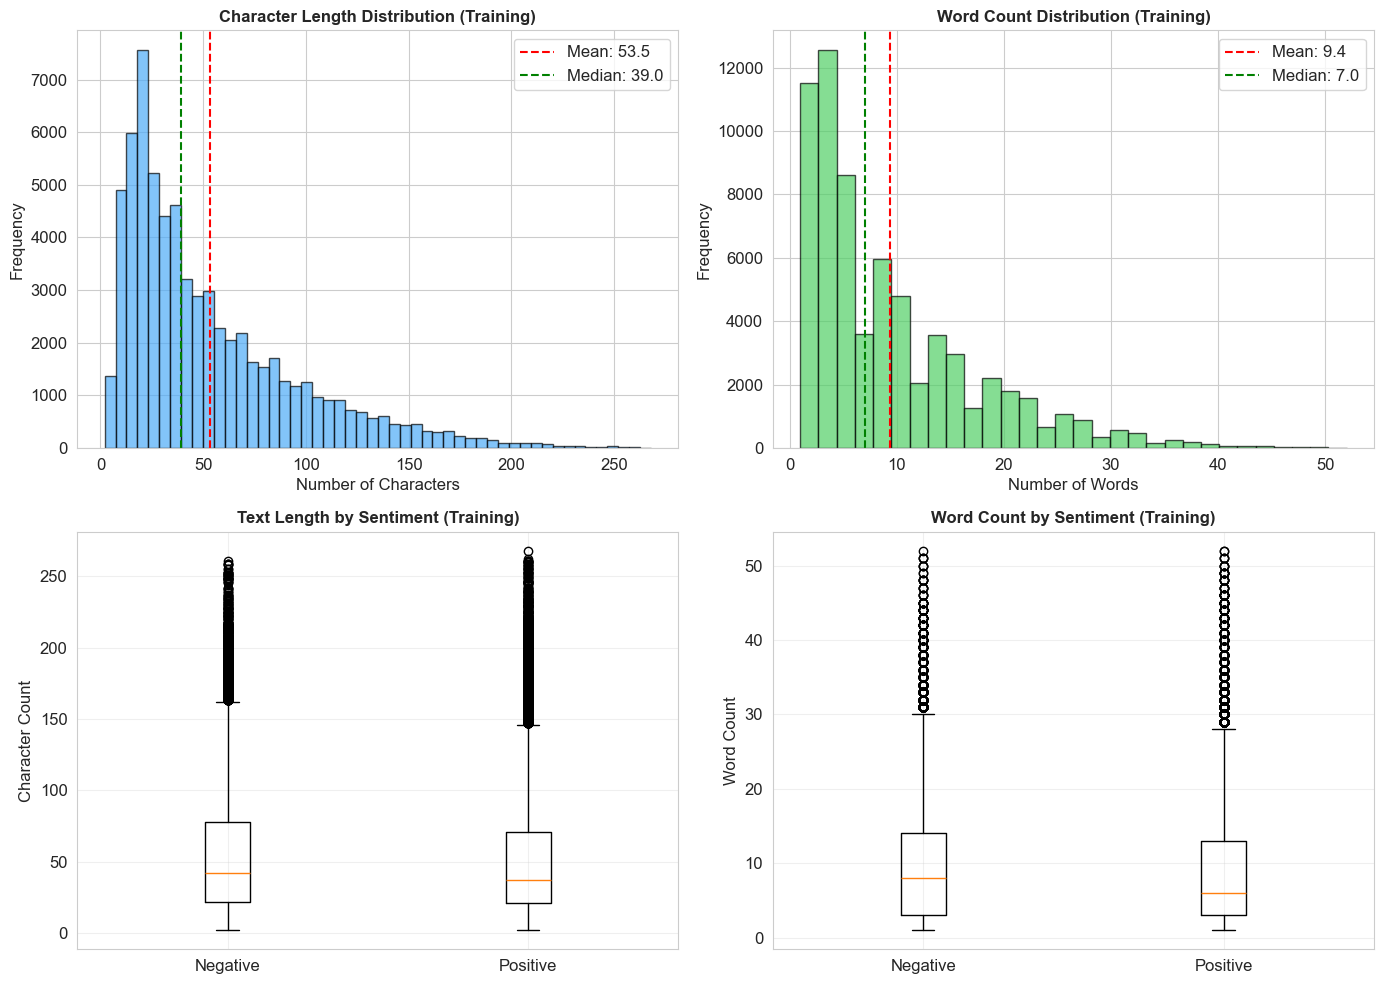


Text Length Statistics by Sentiment:
          text_length                                                      \
                count       mean        std  min   25%   50%   75%    max   
sentiment                                                                   
Negative      29780.0  55.408865  43.526629  2.0  22.0  42.0  78.0  261.0   
Positive      37569.0  51.996912  43.253736  2.0  21.0  37.0  71.0  268.0   

          word_count                                                 
               count      mean       std  min  25%  50%   75%   max  
sentiment                                                            
Negative     29780.0  9.882874  8.157512  1.0  3.0  8.0  14.0  52.0  
Positive     37569.0  9.034363  7.987037  1.0  3.0  6.0  13.0  52.0  


In [9]:
# Text length distribution
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Character length distribution
axes[0, 0].hist(sst2_train_df['text_length'], bins=50, alpha=0.7, color='#4dabf7', edgecolor='black')
axes[0, 0].axvline(sst2_train_df['text_length'].mean(), color='red', linestyle='--', label=f'Mean: {sst2_train_df["text_length"].mean():.1f}')
axes[0, 0].axvline(sst2_train_df['text_length'].median(), color='green', linestyle='--', label=f'Median: {sst2_train_df["text_length"].median():.1f}')
axes[0, 0].set_title('Character Length Distribution (Training)', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Number of Characters')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].legend()

# Word count distribution
axes[0, 1].hist(sst2_train_df['word_count'], bins=30, alpha=0.7, color='#51cf66', edgecolor='black')
axes[0, 1].axvline(sst2_train_df['word_count'].mean(), color='red', linestyle='--', label=f'Mean: {sst2_train_df["word_count"].mean():.1f}')
axes[0, 1].axvline(sst2_train_df['word_count'].median(), color='green', linestyle='--', label=f'Median: {sst2_train_df["word_count"].median():.1f}')
axes[0, 1].set_title('Word Count Distribution (Training)', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Number of Words')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].legend()

# Box plot for text length by sentiment
train_df_viz = sst2_train_df.copy()
train_df_viz['sentiment'] = train_df_viz['label'].map({0: 'Negative', 1: 'Positive'})
axes[1, 0].boxplot([train_df_viz[train_df_viz['sentiment'] == 'Negative']['text_length'],
                     train_df_viz[train_df_viz['sentiment'] == 'Positive']['text_length']],
                    labels=['Negative', 'Positive'])
axes[1, 0].set_title('Text Length by Sentiment (Training)', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Character Count')
axes[1, 0].grid(True, alpha=0.3)

# Box plot for word count by sentiment
axes[1, 1].boxplot([train_df_viz[train_df_viz['sentiment'] == 'Negative']['word_count'],
                     train_df_viz[train_df_viz['sentiment'] == 'Positive']['word_count']],
                    labels=['Negative', 'Positive'])
axes[1, 1].set_title('Word Count by Sentiment (Training)', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Word Count')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistical comparison between sentiments
print("\nText Length Statistics by Sentiment:")
print("=" * 50)
print(train_df_viz.groupby('sentiment')[['text_length', 'word_count']].describe())


## 4. Text Preprocessing Pipeline

Based on the proposal requirements:
- Normalize text (lowercase, whitespace)
- Truncate sequences to 256 tokens for optimal GPU memory usage


In [15]:
import re

def preprocess_text(text, lowercase=True, normalize_whitespace=True):
    """
    Preprocess text for sentiment classification.
    
    Args:
        text: Input text string
        lowercase: Whether to convert to lowercase
        normalize_whitespace: Whether to normalize whitespace
    
    Returns:
        Preprocessed text string
    """
    # Remove extra whitespace
    if normalize_whitespace:
        text = ' '.join(text.split())
    
    # Convert to lowercase
    if lowercase:
        text = text.lower()
    
    # Remove HTML tags if any
    text = re.sub(r'<[^>]+>', '', text)
    
    # Remove URLs
    text = re.sub(r'http\S+|www.\S+', '', text)
    
    # Normalize punctuation (keep basic punctuation for sentiment)
    text = re.sub(r'([!?.]){2,}', r'\1', text)
    
    # Remove extra spaces again
    text = ' '.join(text.split())
    
    return text

# Example preprocessing
sample_text = sst2_train_df.iloc[0]['sentence']
print("Original text:")
print(f"  '{sample_text}'")
print("\nPreprocessed text:")
print(f"  '{preprocess_text(sample_text)}'")

# Apply preprocessing to the entire dataset
print("\nApplying preprocessing to SST-2 dataset...")
sst2_train_df['processed_text'] = sst2_train_df['sentence'].apply(preprocess_text)
sst2_val_df['processed_text'] = sst2_val_df['sentence'].apply(preprocess_text)

print("Preprocessing complete!")

# Show examples of preprocessed text
print("\nSample preprocessed texts:")
for i in range(3):
    print(f"\n{i+1}. Original: {sst2_train_df.iloc[i]['sentence']}")
    print(f"   Processed: {sst2_train_df.iloc[i]['processed_text']}")


Original text:
  'hide new secretions from the parental units '

Preprocessed text:
  'hide new secretions from the parental units'

Applying preprocessing to SST-2 dataset...
Preprocessing complete!

Sample preprocessed texts:

1. Original: hide new secretions from the parental units 
   Processed: hide new secretions from the parental units

2. Original: contains no wit , only labored gags 
   Processed: contains no wit , only labored gags

3. Original: that loves its characters and communicates something rather beautiful about human nature 
   Processed: that loves its characters and communicates something rather beautiful about human nature


In [25]:
# Analyze word frequency distribution
sorted_words = vocab_counter.most_common()
frequencies = [count for word, count in sorted_words]

# Calculate coverage for different vocabulary sizes
def calculate_coverage(vocab_counter, vocab_size):
    """Calculate what percentage of total words are covered by top N vocabulary."""
    total = sum(vocab_counter.values())
    top_words = vocab_counter.most_common(vocab_size)
    covered = sum(count for word, count in top_words)
    return covered / total * 100

# Test different vocabulary sizes
vocab_sizes = [100, 500, 1000, 2000, 3000, 5000, 8000, 10000, 15000, 20000]
coverages = []

print("\n📈 Vocabulary Coverage Analysis:")
print("=" * 50)
print(f"{'Vocab Size':>12} | {'Coverage':>10} | {'New Words':>12}")
print("-" * 40)

for size in vocab_sizes:
    if size <= unique_words:
        coverage = calculate_coverage(vocab_counter, size)
        coverages.append(coverage)
        print(f"{size:12,} | {coverage:9.2f}% | {size:12,}")
    else:
        coverages.append(100.0)
        print(f"{size:12,} | {100.00:9.2f}% | {unique_words:12,} (all)")

# Find vocabulary size for specific coverage targets
coverage_targets = [90, 95, 98, 99, 99.5, 99.9]
print(f"\n🎯 Vocabulary Size for Coverage Targets:")
print("-" * 40)

for target in coverage_targets:
    cumsum = 0
    for i, (word, count) in enumerate(sorted_words):
        cumsum += count
        if (cumsum / total_words * 100) >= target:
            print(f"{target:5.1f}% coverage: {i+1:6,} words")
            break



📈 Vocabulary Coverage Analysis:
  Vocab Size |   Coverage |    New Words
----------------------------------------
         100 |     45.99% |          100
         500 |     63.53% |          500
       1,000 |     71.40% |        1,000
       2,000 |     79.55% |        2,000
       3,000 |     84.31% |        3,000
       5,000 |     90.05% |        5,000
       8,000 |     95.05% |        8,000
      10,000 |     97.26% |       10,000
      15,000 |    100.00% |       14,759 (all)
      20,000 |    100.00% |       14,759 (all)

🎯 Vocabulary Size for Coverage Targets:
----------------------------------------
 90.0% coverage:  4,977 words
 95.0% coverage:  7,960 words
 98.0% coverage: 10,824 words
 99.0% coverage: 12,232 words
 99.5% coverage: 13,162 words
 99.9% coverage: 14,202 words


## 5. Tokenization with Transformers

Using HuggingFace AutoTokenizer for tokenization, as specified in the proposal.


In [26]:
# Initialize tokenizer - using BERT as baseline for comparison
# You can change this to any other model checkpoint
MODEL_NAME = "bert-base-uncased"
MAX_LENGTH = 256  # As specified in the proposal

print(f"Loading tokenizer: {MODEL_NAME}")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Example tokenization
sample_text = sst2_train_df.iloc[0]['processed_text']
print(f"\nOriginal text: {sample_text}")

# Tokenize
tokens = tokenizer.tokenize(sample_text)
print(f"\nTokens ({len(tokens)} tokens): {tokens[:20]}...")  # Show first 20 tokens

# Convert to IDs
token_ids = tokenizer.encode(sample_text, add_special_tokens=True, max_length=MAX_LENGTH, truncation=True)
print(f"\nToken IDs ({len(token_ids)} ids): {token_ids[:20]}...")

# Decode back to verify
decoded_text = tokenizer.decode(token_ids, skip_special_tokens=True)
print(f"\nDecoded text: {decoded_text}")


Loading tokenizer: bert-base-uncased

Original text: hide new secretions from the parental units

Tokens (8 tokens): ['hide', 'new', 'secret', '##ions', 'from', 'the', 'parental', 'units']...

Token IDs (10 ids): [101, 5342, 2047, 3595, 8496, 2013, 1996, 18643, 3197, 102]...

Decoded text: hide new secretions from the parental units


In [27]:
# Tokenize entire dataset in batches for efficiency
def tokenize_dataset(texts, tokenizer, max_length=256, batch_size=32):
    """
    Tokenize a list of texts in batches.
    
    Returns:
        Dictionary with 'input_ids', 'attention_mask', and 'token_lengths'
    """
    all_input_ids = []
    all_attention_masks = []
    all_token_lengths = []
    
    for i in tqdm(range(0, len(texts), batch_size), desc="Tokenizing"):
        batch_texts = texts[i:i+batch_size]
        
        # Tokenize batch
        encoded = tokenizer(
            batch_texts,
            add_special_tokens=True,
            max_length=max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        all_input_ids.extend(encoded['input_ids'].tolist())
        all_attention_masks.extend(encoded['attention_mask'].tolist())
        
        # Calculate actual token lengths (excluding padding)
        token_lengths = encoded['attention_mask'].sum(dim=1).tolist()
        all_token_lengths.extend(token_lengths)
    
    return {
        'input_ids': all_input_ids,
        'attention_mask': all_attention_masks,
        'token_lengths': all_token_lengths
    }

# Tokenize training data
print("Tokenizing training set...")
train_texts = sst2_train_df['processed_text'].tolist()
train_tokenized = tokenize_dataset(train_texts, tokenizer, MAX_LENGTH)

# Add token lengths to dataframe
sst2_train_df['token_length'] = train_tokenized['token_lengths']

print(f"Tokenization complete!")
print(f"Average token length: {np.mean(train_tokenized['token_lengths']):.2f}")
print(f"Max token length: {np.max(train_tokenized['token_lengths'])}")
print(f"Min token length: {np.min(train_tokenized['token_lengths'])}")


Tokenizing training set...


Tokenizing: 100%|██████████| 2105/2105 [00:06<00:00, 339.49it/s]


Tokenization complete!
Average token length: 13.28
Max token length: 66
Min token length: 3


## 6. Token Distribution Analysis


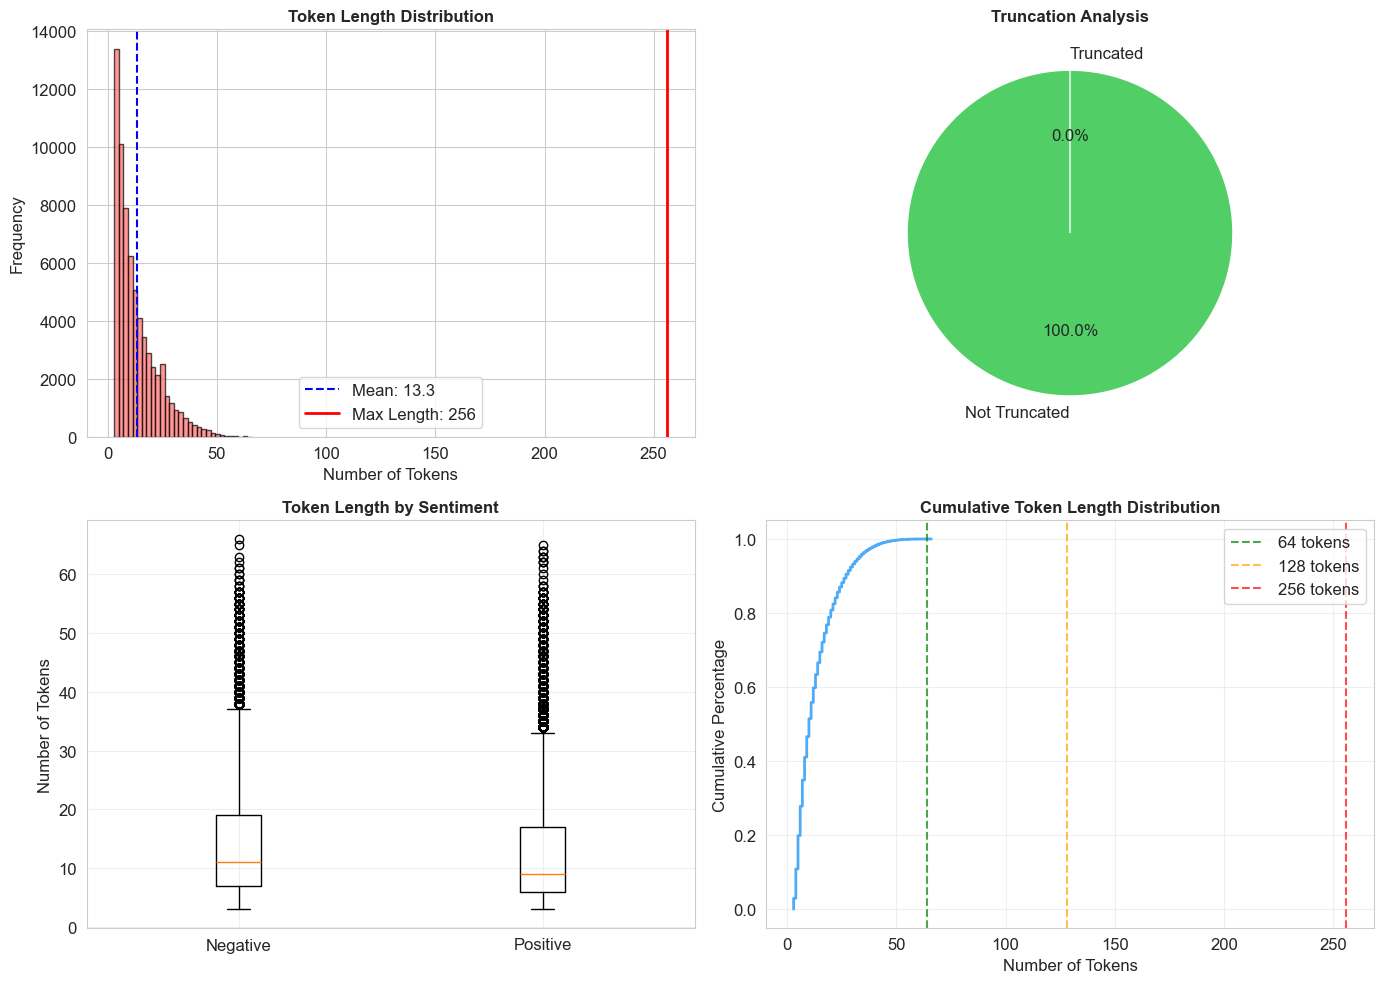


Token Length Statistics:
Samples truncated at 256 tokens: 0 (0.00%)
Samples within 128 tokens: 67349 (100.00%)
Samples within 64 tokens: 67346 (100.00%)


In [28]:
# Token distribution analysis
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Token length distribution
axes[0, 0].hist(sst2_train_df['token_length'], bins=30, alpha=0.7, color='#ff6b6b', edgecolor='black')
axes[0, 0].axvline(sst2_train_df['token_length'].mean(), color='blue', linestyle='--', 
                   label=f'Mean: {sst2_train_df["token_length"].mean():.1f}')
axes[0, 0].axvline(MAX_LENGTH, color='red', linestyle='-', linewidth=2, 
                   label=f'Max Length: {MAX_LENGTH}')
axes[0, 0].set_title('Token Length Distribution', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Number of Tokens')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].legend()

# Truncation analysis
truncated = (sst2_train_df['token_length'] == MAX_LENGTH).sum()
not_truncated = len(sst2_train_df) - truncated
axes[0, 1].pie([not_truncated, truncated], labels=['Not Truncated', 'Truncated'], 
               autopct='%1.1f%%', colors=['#51cf66', '#ff6b6b'], startangle=90)
axes[0, 1].set_title('Truncation Analysis', fontsize=12, fontweight='bold')

# Token length by sentiment
axes[1, 0].boxplot([sst2_train_df[sst2_train_df['label'] == 0]['token_length'],
                     sst2_train_df[sst2_train_df['label'] == 1]['token_length']],
                    labels=['Negative', 'Positive'])
axes[1, 0].set_title('Token Length by Sentiment', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Number of Tokens')
axes[1, 0].grid(True, alpha=0.3)

# Cumulative distribution
sorted_lengths = np.sort(sst2_train_df['token_length'])
cumulative = np.arange(1, len(sorted_lengths) + 1) / len(sorted_lengths)
axes[1, 1].plot(sorted_lengths, cumulative, linewidth=2, color='#4dabf7')
axes[1, 1].axvline(64, color='green', linestyle='--', alpha=0.7, label='64 tokens')
axes[1, 1].axvline(128, color='orange', linestyle='--', alpha=0.7, label='128 tokens')
axes[1, 1].axvline(256, color='red', linestyle='--', alpha=0.7, label='256 tokens')
axes[1, 1].set_title('Cumulative Token Length Distribution', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Number of Tokens')
axes[1, 1].set_ylabel('Cumulative Percentage')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].legend()

plt.tight_layout()
plt.show()

# Statistics
print("\nToken Length Statistics:")
print("=" * 50)
print(f"Samples truncated at {MAX_LENGTH} tokens: {truncated} ({truncated/len(sst2_train_df)*100:.2f}%)")
print(f"Samples within 128 tokens: {(sst2_train_df['token_length'] <= 128).sum()} ({(sst2_train_df['token_length'] <= 128).sum()/len(sst2_train_df)*100:.2f}%)")
print(f"Samples within 64 tokens: {(sst2_train_df['token_length'] <= 64).sum()} ({(sst2_train_df['token_length'] <= 64).sum()/len(sst2_train_df)*100:.2f}%)")


## 7. Word Clouds for Sentiment Classes


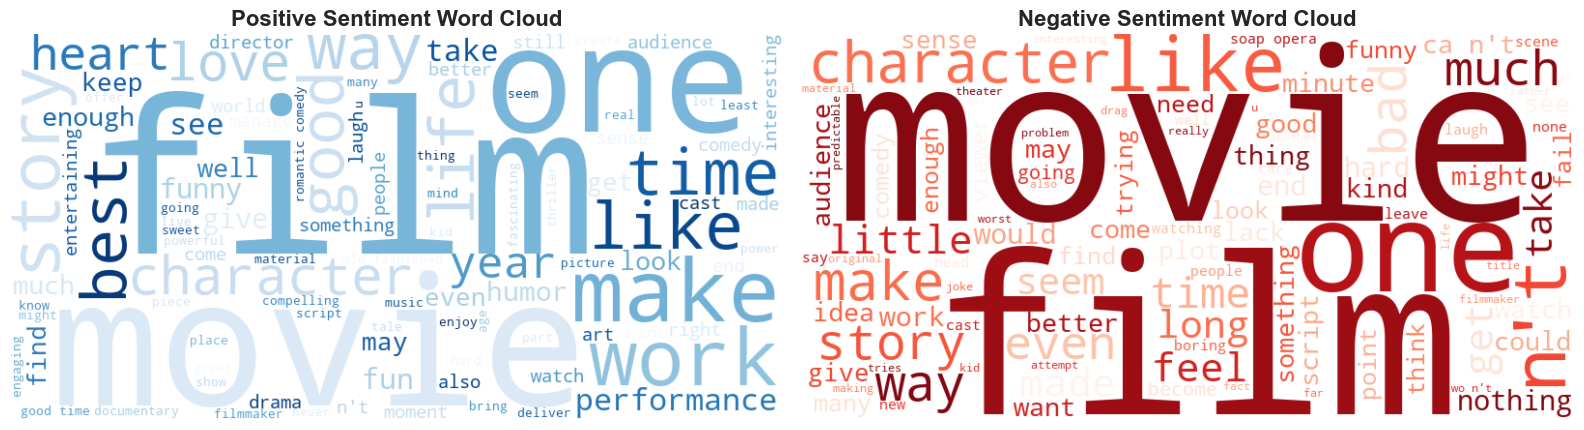

In [29]:
# Create word clouds for each sentiment
from wordcloud import WordCloud

# Get stopwords
stop_words = set(stopwords.words('english'))

# Separate texts by sentiment
positive_texts = ' '.join(sst2_train_df[sst2_train_df['label'] == 1]['processed_text'].values)
negative_texts = ' '.join(sst2_train_df[sst2_train_df['label'] == 0]['processed_text'].values)

# Create word clouds
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Positive sentiment word cloud
positive_wc = WordCloud(width=800, height=400, 
                        background_color='white',
                        stopwords=stop_words,
                        colormap='Blues',
                        max_words=100).generate(positive_texts)

axes[0].imshow(positive_wc, interpolation='bilinear')
axes[0].set_title('Positive Sentiment Word Cloud', fontsize=16, fontweight='bold')
axes[0].axis('off')

# Negative sentiment word cloud
negative_wc = WordCloud(width=800, height=400,
                        background_color='white',
                        stopwords=stop_words,
                        colormap='Reds',
                        max_words=100).generate(negative_texts)

axes[1].imshow(negative_wc, interpolation='bilinear')
axes[1].set_title('Negative Sentiment Word Cloud', fontsize=16, fontweight='bold')
axes[1].axis('off')

plt.tight_layout()
plt.show()


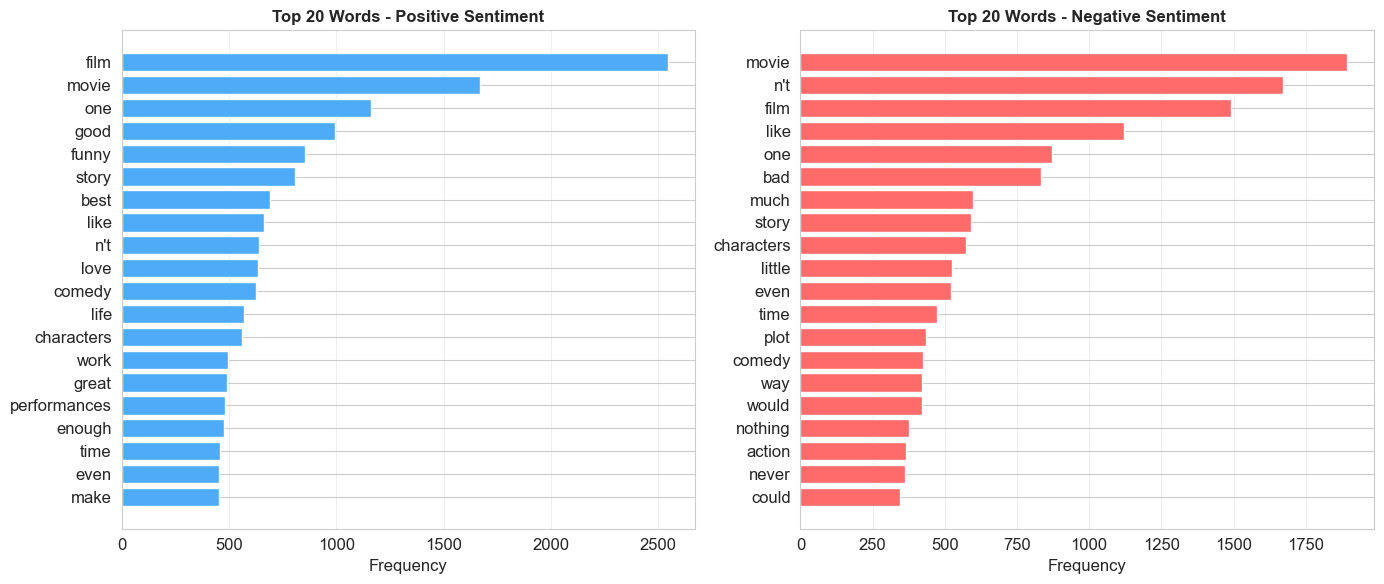

Unique top words in positive sentiment: ['life', 'great', 'performances', 'enough', 'make', 'best', 'good', 'work', 'funny', 'love']
Unique top words in negative sentiment: ['plot', 'little', 'bad', 'never', 'would', 'could', 'nothing', 'much', 'way', 'action']


In [30]:
# Most frequent words analysis
from collections import Counter

def get_top_words(texts, n=20, remove_stopwords=True):
    """Get top n most frequent words from texts."""
    all_words = []
    for text in texts:
        words = text.lower().split()
        if remove_stopwords:
            words = [w for w in words if w not in stop_words and len(w) > 2]
        all_words.extend(words)
    
    word_counts = Counter(all_words)
    return word_counts.most_common(n)

# Get top words for each sentiment
positive_top_words = get_top_words(sst2_train_df[sst2_train_df['label'] == 1]['processed_text'])
negative_top_words = get_top_words(sst2_train_df[sst2_train_df['label'] == 0]['processed_text'])

# Visualize top words
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Positive sentiment top words
pos_words, pos_counts = zip(*positive_top_words)
axes[0].barh(range(len(pos_words)), pos_counts, color='#4dabf7')
axes[0].set_yticks(range(len(pos_words)))
axes[0].set_yticklabels(pos_words)
axes[0].invert_yaxis()
axes[0].set_xlabel('Frequency')
axes[0].set_title('Top 20 Words - Positive Sentiment', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='x')

# Negative sentiment top words
neg_words, neg_counts = zip(*negative_top_words)
axes[1].barh(range(len(neg_words)), neg_counts, color='#ff6b6b')
axes[1].set_yticks(range(len(neg_words)))
axes[1].set_yticklabels(neg_words)
axes[1].invert_yaxis()
axes[1].set_xlabel('Frequency')
axes[1].set_title('Top 20 Words - Negative Sentiment', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

# Find unique words for each sentiment
pos_unique = set([w for w, _ in positive_top_words]) - set([w for w, _ in negative_top_words])
neg_unique = set([w for w, _ in negative_top_words]) - set([w for w, _ in positive_top_words])

print("Unique top words in positive sentiment:", list(pos_unique)[:10])
print("Unique top words in negative sentiment:", list(neg_unique)[:10])


## 8. Save Preprocessed Data and Create Splits

As per the proposal:
- SST-2: follow GLUE splits (≈67k train, 872 dev, 1,821 test)
- Carve out 5% of the train set as an internal validation set for hyperparameters


In [31]:
# Create train/validation split (5% for internal validation)
from sklearn.model_selection import train_test_split

# Split training data
train_indices = sst2_train_df.index.tolist()
train_idx, internal_val_idx = train_test_split(
    train_indices, 
    test_size=0.05,  # 5% for internal validation
    random_state=42,
    stratify=sst2_train_df['label']  # Maintain label balance
)

# Create internal splits
sst2_train_split = sst2_train_df.iloc[train_idx].reset_index(drop=True)
sst2_internal_val = sst2_train_df.iloc[internal_val_idx].reset_index(drop=True)

print("Dataset Splits:")
print("=" * 50)
print(f"Training set: {len(sst2_train_split)} samples")
print(f"Internal validation: {len(sst2_internal_val)} samples")
print(f"Official validation: {len(sst2_val_df)} samples")
print(f"Test set: {len(sst2_dataset['test'])} samples")

# Verify label distribution is maintained
print("\nLabel distribution in splits:")
print(f"Training: {sst2_train_split['label'].value_counts().to_dict()}")
print(f"Internal Val: {sst2_internal_val['label'].value_counts().to_dict()}")
print(f"Official Val: {sst2_val_df['label'].value_counts().to_dict()}")


Dataset Splits:
Training set: 63981 samples
Internal validation: 3368 samples
Official validation: 872 samples
Test set: 1821 samples

Label distribution in splits:
Training: {1: 35690, 0: 28291}
Internal Val: {1: 1879, 0: 1489}
Official Val: {1: 444, 0: 428}


In [32]:
# Save preprocessed data
import pickle
import json

# Create data directory if it doesn't exist
os.makedirs('../data/processed', exist_ok=True)

# Prepare data dictionaries
def prepare_dataset_dict(df, tokenized_data=None):
    """Prepare dataset dictionary for saving."""
    dataset_dict = {
        'texts': df['sentence'].tolist(),
        'processed_texts': df['processed_text'].tolist(),
        'labels': df['label'].tolist(),
        'text_lengths': df['text_length'].tolist(),
        'word_counts': df['word_count'].tolist(),
    }
    
    if tokenized_data and 'token_length' in df.columns:
        dataset_dict['token_lengths'] = df['token_length'].tolist()
    
    return dataset_dict

# Prepare datasets
train_data = prepare_dataset_dict(sst2_train_split, train_tokenized)
internal_val_data = prepare_dataset_dict(sst2_internal_val, train_tokenized)
val_data = prepare_dataset_dict(sst2_val_df)

# Save as pickle files
with open('../data/processed/sst2_train.pkl', 'wb') as f:
    pickle.dump(train_data, f)
    
with open('../data/processed/sst2_internal_val.pkl', 'wb') as f:
    pickle.dump(internal_val_data, f)
    
with open('../data/processed/sst2_val.pkl', 'wb') as f:
    pickle.dump(val_data, f)

# Also save tokenizer configuration
tokenizer_config = {
    'model_name': MODEL_NAME,
    'max_length': MAX_LENGTH,
    'vocab_size': tokenizer.vocab_size
}

with open('../data/processed/tokenizer_config.json', 'w') as f:
    json.dump(tokenizer_config, f, indent=2)

print("\nData saved successfully!")
print(f"Files saved in: ../data/processed/")
print("  - sst2_train.pkl")
print("  - sst2_internal_val.pkl")
print("  - sst2_val.pkl")
print("  - tokenizer_config.json")



Data saved successfully!
Files saved in: ../data/processed/
  - sst2_train.pkl
  - sst2_internal_val.pkl
  - sst2_val.pkl
  - tokenizer_config.json


In [33]:
# Build vocabulary from the training set
from collections import Counter
import string

def build_vocabulary(texts, lowercase=True):
    """Build vocabulary with word frequencies from texts."""
    word_counter = Counter()
    
    for text in tqdm(texts, desc="Building vocabulary"):
        # Basic tokenization - split on whitespace and punctuation
        if lowercase:
            text = text.lower()
        
        # Simple word tokenization (keeping it consistent with preprocessing)
        words = text.split()
        
        # Optional: remove pure punctuation tokens
        words = [w for w in words if w not in string.punctuation]
        
        word_counter.update(words)
    
    return word_counter

# Build vocabulary from training data only (important for preventing data leakage)
print("Building vocabulary from training set...")
train_texts = sst2_train_split['processed_text'].tolist()
vocab_counter = build_vocabulary(train_texts)

# Get vocabulary statistics
total_words = sum(vocab_counter.values())  # Total word count
unique_words = len(vocab_counter)  # Vocabulary size

print(f"\n📊 Vocabulary Statistics:")
print("=" * 50)
print(f"Total words in training set: {total_words:,}")
print(f"Unique words (vocabulary size): {unique_words:,}")
print(f"Average word frequency: {total_words/unique_words:.2f}")

# Show most common words
print(f"\n🔝 Top 20 Most Frequent Words:")
print("-" * 30)
for word, count in vocab_counter.most_common(20):
    print(f"{word:15} : {count:6,} ({count/total_words*100:.2f}%)")


Building vocabulary from training set...


Building vocabulary: 100%|██████████| 63981/63981 [00:00<00:00, 520745.47it/s]


📊 Vocabulary Statistics:
Total words in training set: 557,970
Unique words (vocabulary size): 14,759
Average word frequency: 37.81

🔝 Top 20 Most Frequent Words:
------------------------------
the             : 25,814 (4.63%)
a               : 20,511 (3.68%)
and             : 18,903 (3.39%)
of              : 17,014 (3.05%)
to              : 11,896 (2.13%)
's              :  8,336 (1.49%)
is              :  8,272 (1.48%)
that            :  7,377 (1.32%)
in              :  7,110 (1.27%)
it              :  6,733 (1.21%)
as              :  4,803 (0.86%)
with            :  4,521 (0.81%)
an              :  3,947 (0.71%)
film            :  3,828 (0.69%)
for             :  3,737 (0.67%)
its             :  3,731 (0.67%)
movie           :  3,397 (0.61%)
this            :  3,209 (0.58%)
you             :  2,600 (0.47%)
but             :  2,552 (0.46%)


In [7]:
import pickle

with open("../data/processed/sst2_internal_val.pkl", "rb") as f:
    d = pickle.load(f)

print("Keys:", d.keys())


Keys: dict_keys(['texts', 'processed_texts', 'labels', 'text_lengths', 'word_counts', 'token_lengths'])


Total merged samples = 68221
Train size = 54576
Val size   = 6822
Test size  = 6823


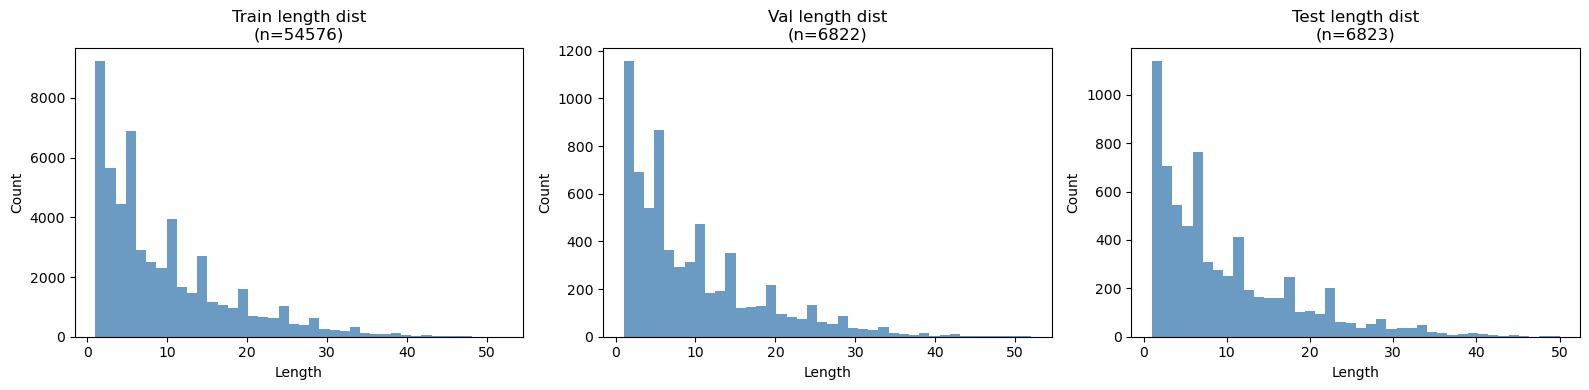

In [8]:
import pickle
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

# -----------------------------
# 1. Load pkl helper
# -----------------------------
def load_pkl(path):
    with open(path, "rb") as f:
        return pickle.load(f)

def save_pkl(obj, path):
    with open(path, "wb") as f:
        pickle.dump(obj, f)

# -----------------------------
# 2. Load the three datasets
# -----------------------------
root = Path("../data/processed")  

files = [
    root/"sst2_train.pkl",
    root/"sst2_val.pkl",
    root/"sst2_internal_val.pkl"
]

datasets = [load_pkl(f) for f in files]

# -----------------------------
# 3. Merge ALL keys (not only 3)
# -----------------------------
all_keys = set().union(*[d.keys() for d in datasets])

merged = {k: [] for k in all_keys}

for data in datasets:
    for k in all_keys:
        merged[k] += data.get(k, [None] * len(data["texts"]))

N = len(merged["texts"])
print(f"Total merged samples = {N}")


# -----------------------------
# 4. Random split 8 : 1 : 1
# -----------------------------
indices = np.random.permutation(N)

n_train = int(N * 0.8)
n_val   = int(N * 0.1)
n_test  = N - n_train - n_val

train_idx = indices[:n_train]
val_idx   = indices[n_train:n_train+n_val]
test_idx  = indices[n_train+n_val:]

def subset(data, idx):
    return {k: [v[i] for i in idx] for k, v in data.items()}

split_train = subset(merged, train_idx)
split_val   = subset(merged, val_idx)
split_test  = subset(merged, test_idx)

print(f"Train size = {len(split_train['texts'])}")
print(f"Val size   = {len(split_val['texts'])}")
print(f"Test size  = {len(split_test['texts'])}")


# -----------------------------
# 5. Save files
# -----------------------------
save_pkl(split_train, root/"sst2_train.pkl")
save_pkl(split_val,   root/"sst2_val.pkl")
save_pkl(split_test,  root/"sst2_test.pkl")


# -----------------------------
# 6. Plot length distributions
# -----------------------------
plt.figure(figsize=(16,4))

splits = {
    "Train": split_train,
    "Val":   split_val,
    "Test":  split_test
}

for i, (name, data) in enumerate(splits.items()):
    plt.subplot(1,3,i+1)
    plt.hist(data["word_counts"], bins=40, color="steelblue", alpha=0.8)
    plt.title(f"{name} length dist\n(n={len(data['texts'])})")
    plt.xlabel("Length")
    plt.ylabel("Count")

plt.tight_layout()
plt.show()


In [6]:
from collections import Counter

def show_label_dist(name, data):
    labels = data["labels"]
    counter = Counter(labels)
    total = len(labels)
    
    print(f"\n=== {name} Label Distribution (n={total}) ===")
    for lbl, cnt in sorted(counter.items()):
        print(f"Label {lbl}: {cnt} ({cnt/total:.2%})")


show_label_dist("Train", split_train)
show_label_dist("Val", split_val)
show_label_dist("Test", split_test)



=== Train Label Distribution (n=54576) ===
Label 0: 24125 (44.20%)
Label 1: 30451 (55.80%)

=== Val Label Distribution (n=6822) ===
Label 0: 3066 (44.94%)
Label 1: 3756 (55.06%)

=== Test Label Distribution (n=6823) ===
Label 0: 3017 (44.22%)
Label 1: 3806 (55.78%)
